# <div style="font-family: Georgia, serif"><div style="text-align: center;color: #E67E02"><div><h1>Assignment 2</h1></div></div><div style="color: #0377DE; font-size: 20px"><span style="padding-right: 100px;">Name: Koushik Mahanta</span > <span>Roll No.: 002011001106</span></div></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from sklearn.datasets import (load_iris, load_breast_cancer)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (   
                                classification_report, 
                                confusion_matrix, 
                                accuracy_score, 
                                roc_curve, 
                                roc_auc_score,
                                auc
                            )

In [31]:
def printClassficationReport(dataset, classifier, random_state, trin_size, **args):
    """This function takes a model and its configurations and prints the 
    classification report and confusion matrix, if the classifier is a 
    DecisionTreeClassifier then it displays the tree"""
    
    X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                        dataset.target, 
                                                        test_size=trin_size, 
                                                        stratify=dataset.target, 
                                                        random_state=random_state)
    
    trained_model = classifier(**args).fit(X_train, y_train)
    y_prediction = trained_model.predict(X_test)

    print(f"======================== Model = {classifier.__name__} ========================")
    print("------------------------- Classification Report ----------------------")
    print(classification_report(y_test, 
                                y_prediction,  
                                labels=np.unique(y_prediction)))
    
    print("---------------------------- Confusion Mtrix -------------------------")
    cf_matrix = confusion_matrix(y_test, y_prediction)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), 
                annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    print("\n\n")

In [4]:
def getModelScores(dataset, model_params, k_fold):
    """This function performs k_fold Grid search cross validation on 
    the dataset for all the models in `model_params` using all combinations 
    of configuraions mentioned for that model and returns a DataFrame 
    containing maximum test score configurations for each model"""
    scores = []
    for model_name, mp in model_params.items():
        clf =  GridSearchCV(mp['model'], mp['params'], 
                            cv=5, 
                            return_train_score=False)
        
        clf.fit(dataset.data, dataset.target)
        
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
        
    df = pd.DataFrame(scores,
                      columns=['model','best_score','best_params'])
    return df

In [5]:
def getTrainsizeAccuracies(dataset, 
                           classifier, 
                           random_state,
                           /, *, 
                           train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7],
                           **args
                          ):
    
    """
        This function takes a dataset, a classifier and an optional array containing 
        traing sizes. It computes model accuracy scores for each train-test split and
        displays a Model accuracy vs Training size plot
    """
    accuracies = []
    for train_size in train_sizes:
        X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                            dataset.target, 
                                                            train_size=train_size, 
                                                            random_state=random_state)
        if args:
            trained_model = classifier(**args).fit(X_train, y_train)
        else:
            trained_model = classifier().fit(X_train, y_train)
        y_prediction = trained_model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_prediction))
        
    # Plotting the Graph
    plt.plot(np.array(train_sizes)*100, np.array(accuracies)*100)
    plt.title("Model Accuracy vs Training Size (Model = {0})".format(classifier.__name__))
    plt.xlabel("Training Size (%)")
    plt.ylabel("Model Accuracy (%)")
    plt.xticks(np.array(train_sizes)*100)
    plt.show()
        

In [6]:
def displayROCPlot(dataset, classifiers, train_size, random_state, is_multiclass=False, /, **args):
    
    if not is_multiclass:
        
        X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                            dataset.target, 
                                                            train_size=train_size, 
                                                            random_state=random_state)
        r_probs = [0 for _ in range(len(y_test))]
        r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
        r_auc = roc_auc_score(y_test, r_probs)
        plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
    
        for classifier in classifiers:
            trained_model = classifier(**args[classifier.__name__]).fit(X_train, y_train)
            probabilities = trained_model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, probabilities)
            fpr, tpr, _ = roc_curve(y_test, probabilities)
            plt.plot(fpr, tpr, marker='.', label='{0} (AUROC = {1:.3f})'.format(classifier.__name__, roc_auc))
        
        # Title
        plt.title('ROC Plot')
        # Axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # Show legend
        plt.legend() # 
        # Show plot
        plt.show()
        
    else:

        classes = np.unique(dataset.target)
        n_classes = len(classes)
        X = dataset.data
        y = label_binarize(dataset.target, classes=classes)
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

        # Compute ROC curve and ROC area for each class
        for i in range(n_classes):
            r_probs = [0 for _ in range(len(y_test))]
            r_fpr, r_tpr, _ = roc_curve(y_test[:,i], r_probs)
            roc_auc = auc(r_fpr, r_tpr)
            plt.plot(r_tpr, r_tpr, linestyle='--', label='Random prediction (AUROC = {:.3f})'.format(roc_auc))
            
            for classifier in classifiers:
                trained_model = OneVsRestClassifier(classifier(**args[classifier.__name__])).fit(X_train, y_train)
                probabilities = trained_model.predict_proba(X_test)
                fpr, tpr, _ = roc_curve(y_test[:, i], probabilities[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, marker='.', label='{0} (AUROC = {1:.3f})'.format(classifier.__name__, roc_auc))
                
            # Title
            plt.title('ROC Plot for class {0}'.format(dataset.target_names[i]))
            # Axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # Show legend
            plt.legend() # 
            # Show plot
            plt.show()

## Iris Dataset

In [7]:
iris_dataset = load_iris()

### Without Parameter Tunning

#### Comparing Different Training Sizes For Iris Dataset

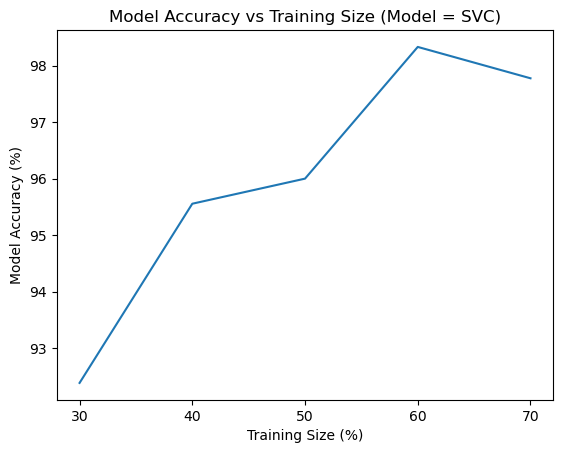

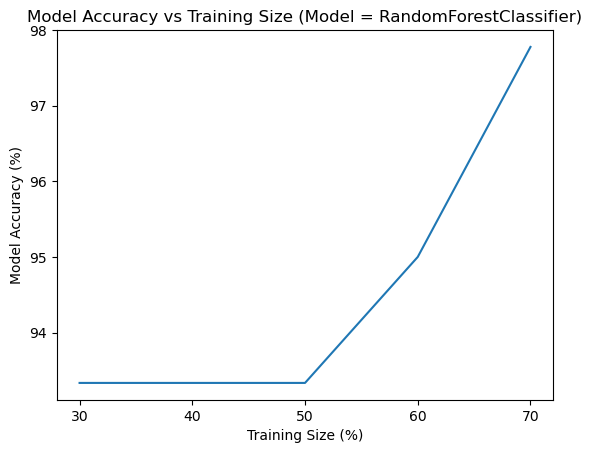

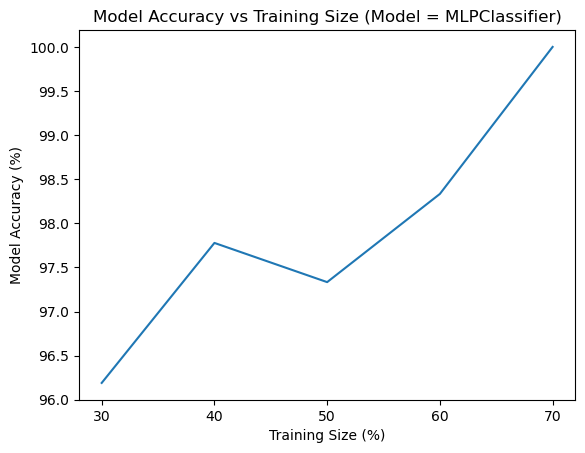

In [8]:
getTrainsizeAccuracies(iris_dataset,
                       SVC,
                       4)

getTrainsizeAccuracies(iris_dataset,
                       RandomForestClassifier,
                       4)

getTrainsizeAccuracies(iris_dataset,
                       MLPClassifier,
                       42,
                       max_iter=1000
                      )

#### Comparing Different Models for Iris Dataset

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      0.94      0.97        35
           2       0.95      1.00      0.97        35

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105

---------------------------- Confusion Mtrix -------------------------


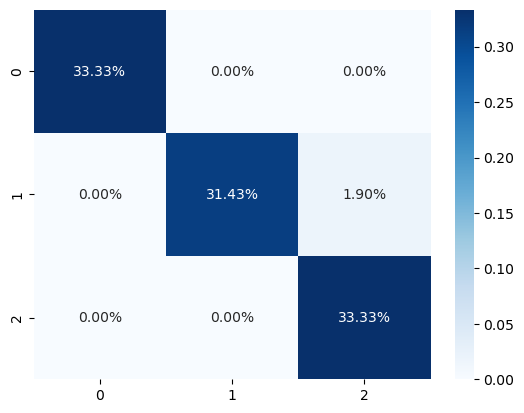




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.85      0.97      0.91        30
           2       0.96      0.83      0.89        30

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90

---------------------------- Confusion Mtrix -------------------------


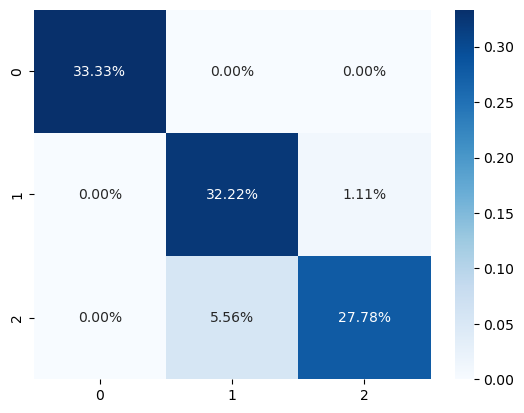




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.93      0.93      0.93        30
           2       0.93      0.93      0.93        30

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90

---------------------------- Confusion Mtrix -------------------------


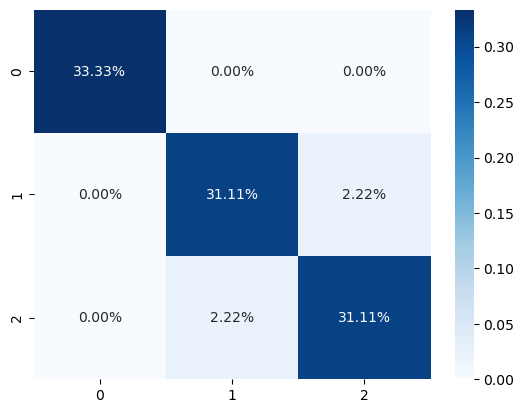

In [33]:
printClassficationReport(iris_dataset, MLPClassifier, 60, 0.7, max_iter=10000)
printClassficationReport(iris_dataset, SVC, 60, 0.6)
printClassficationReport(iris_dataset, RandomForestClassifier, 60, 0.6)

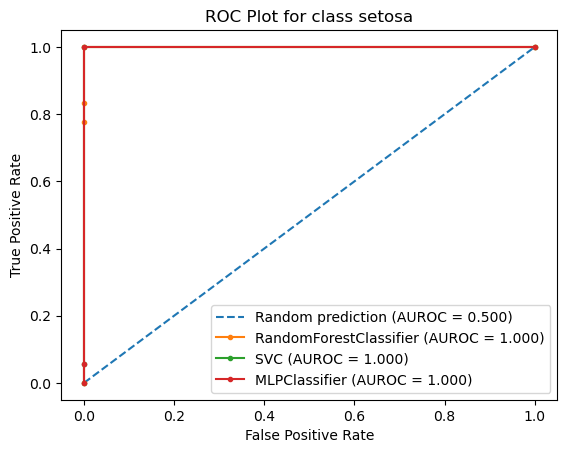

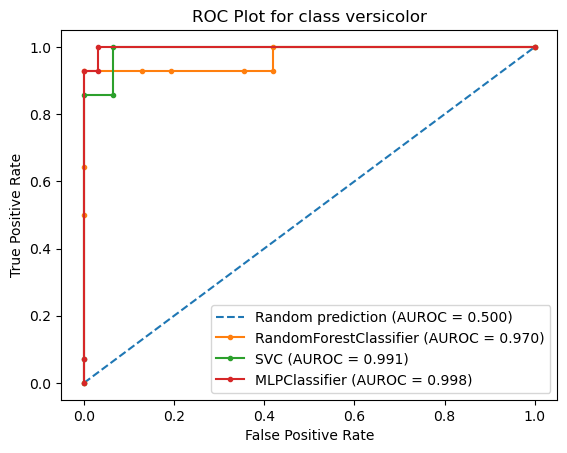

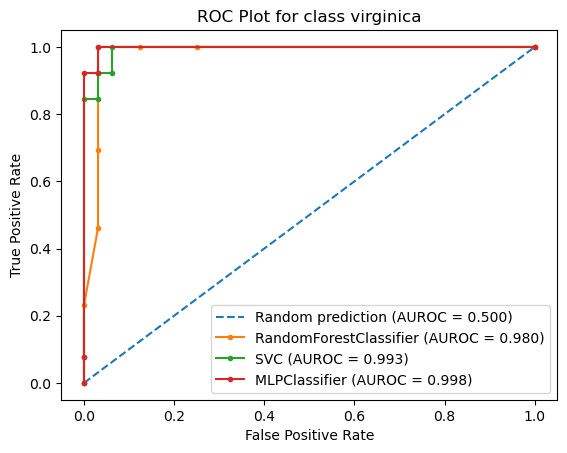

In [19]:
displayROCPlot(iris_dataset, 
               [RandomForestClassifier, SVC, MLPClassifier], 
               0.7, 
               60, 
               True, 
               RandomForestClassifier={}, 
               MLPClassifier={'max_iter':10000}, 
               SVC={'probability':True})

### Parameter tunning

In [43]:
iris_model_params = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [200, 300, 400, 500],
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_features': ["sqrt", "log2", None]
            
        }  
    },
    'MLPClassifier': {
        'model': MLPClassifier(max_iter=10000),
        'params' : {
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.01, 0.1]
        }
    },
    'SVC' : {
        'model': SVC(),
        'params': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [3, 4, 5, 6],
            'coef0': [0, 1, 2, 3, 4, 5]
        }
    }
}

In [45]:
iris_best_model_config = getModelScores(iris_dataset, iris_model_params, 5)

In [54]:
iris_best_model_config

,model,best_score,best_params
0,RandomForestClassifier,0.966667,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
1,MLPClassifier,0.986667,"{'activation': 'identity', 'alpha': 0.001, 'so..."
2,SVC,0.980000,"{'coef0': 0, 'degree': 3, 'kernel': 'linear'}"


In [57]:
print(f"{iris_best_model_config['model'][0]} --> {iris_best_model_config['best_params'][0]}")
print(f"{iris_best_model_config['model'][1]} --> {iris_best_model_config['best_params'][1]}")
print(f"{iris_best_model_config['model'][2]} --> {iris_best_model_config['best_params'][2]}")

RandomForestClassifier --> {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}
MLPClassifier --> {'activation': 'identity', 'alpha': 0.001, 'solver': 'sgd'}
SVC --> {'coef0': 0, 'degree': 3, 'kernel': 'linear'}


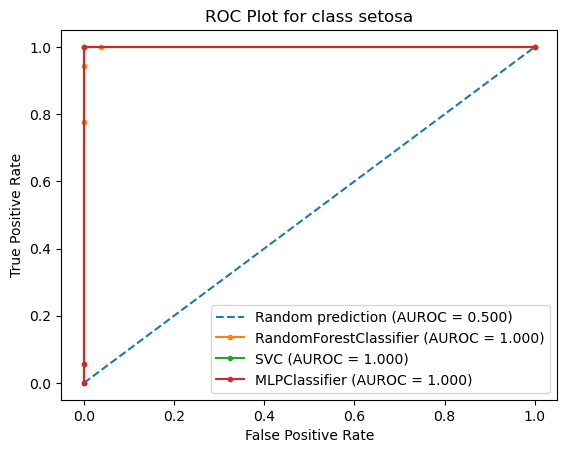

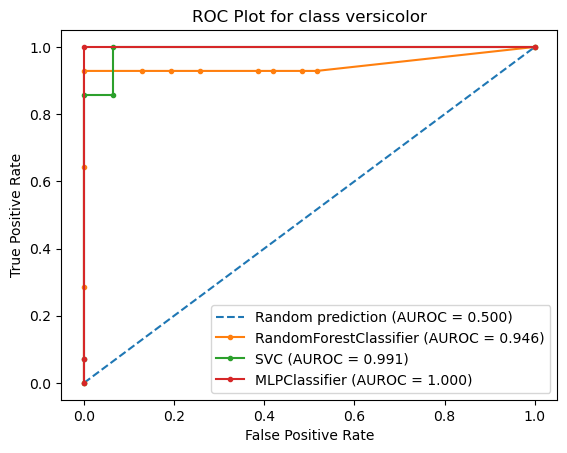

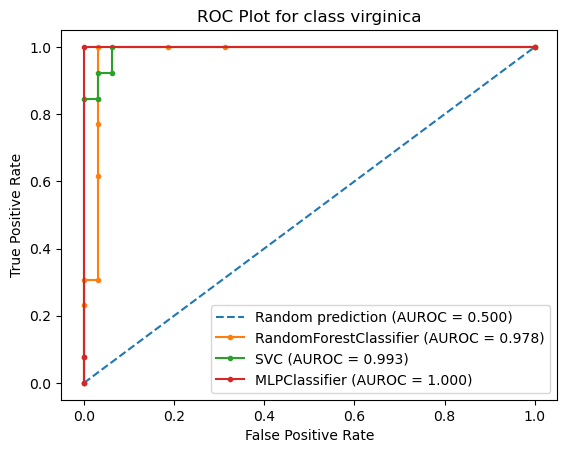

In [63]:
displayROCPlot(iris_dataset, 
               [RandomForestClassifier, SVC, MLPClassifier], 
               0.7, 
               60, 
               True, 
               RandomForestClassifier={'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}, 
               MLPClassifier={'max_iter':10000, 'alpha': 0.001, 'solver': 'sgd'}, 
               SVC={'probability':True, 'coef0': 0, 'degree': 3})

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      0.91      0.96        35
           2       0.92      1.00      0.96        35

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105

---------------------------- Confusion Mtrix -------------------------


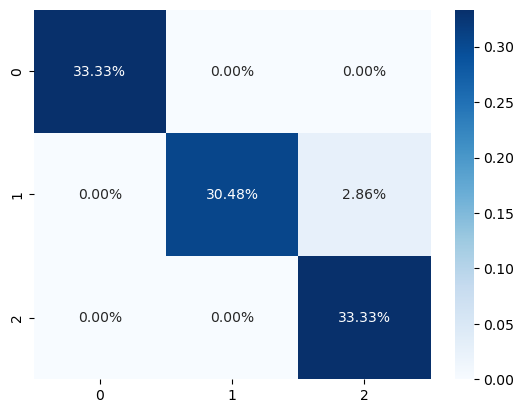




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.85      0.97      0.91        30
           2       0.96      0.83      0.89        30

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90

---------------------------- Confusion Mtrix -------------------------


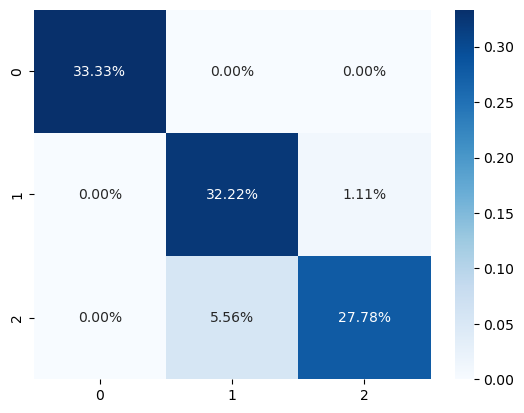




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.93      0.93      0.93        30
           2       0.93      0.93      0.93        30

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90

---------------------------- Confusion Mtrix -------------------------


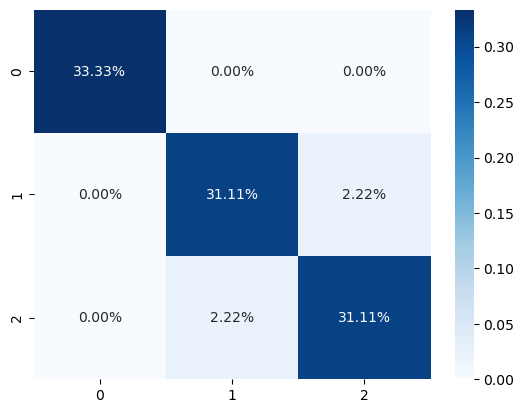

In [64]:
printClassficationReport(iris_dataset, MLPClassifier, 60, 0.7, max_iter=10000, )
printClassficationReport(iris_dataset, SVC, 60, 0.6)
printClassficationReport(iris_dataset, RandomForestClassifier, 60, 0.6, criterion = 'gini', max_features = 'sqrt', n_estimators = 200)

## Ionosphere Dataset

In [ ]:
# downloading the Ionosphere dataset
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv -o data/ionosphere.csv

# Preparing data
ionosphere_df = pd.read_csv('data/ionosphere.csv', header=None)
ionosphere_dataset = Bunch( 
                            data=ionosphere_df.loc[:,0:33], 
                            target=np.where(ionosphere_df[34] == 'g', 0, 1)
                          )

In [ ]:
displayROCPlot(ionosphere_dataset, [RandomForestClassifier, SVC, MLPClassifier], 0.7, 60, RandomForestClassifier={}, MLPClassifier={'max_iter':10000}, SVC={'probability':True})

## Wisconsin Breast Cancer Dataset

In [ ]:
brest_cancer_dataset = load_breast_cancer()